In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model

        s_in = self.base_model.output_channels
        s = 10

        self.conv1 = self.get_group_of_layers(reps, s_in, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()

    def get_group_of_layers(self, reps, s0, s, k=3):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]


def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    base = CPPNNet(widths)
    viz = Net(base, reps=1).to(device)
    viz = nn.DataParallel(viz)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def imgnet_objective(output):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        return -r[:, chan_to_opt].mean()

    xy = get_xy_mesh(size).to(device)
    xy2 = get_xy_mesh([int(i * 1.5) for i in size]).to(device)
    xy4 = get_xy_mesh([int(i * 2.0
                          ) for i in size]).to(device)
    print(xy.shape, xy2.shape, xy4.shape)

    def im_gen_fn(pct_done=0.0, num=128):
        xy_crop = []
        h, w = size
        for i in range(num):
            r = np.random.rand()
            if i == 0:
                x0, x1 = 30, 30 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < (0.5 * (1 - pct_done)):
                x0 = np.random.choice([0, w - h])
                x1 = x0 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < (0.8 * (1 - pct_done)):
                x0 = np.random.randint(0, xy2.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy2.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy2[:, :, y0:y1, x0:x1])
            else:
                x0 = np.random.randint(0, xy4.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy4.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy4[:, :, y0:y1, x0:x1])
                
        xy_crop = torch.cat(xy_crop, 0)
        return viz(xy_crop)

    ims_savedir = '../data/output_ims3/'
    def big_save_fn():
        return None
        xy_big = get_xy_mesh([277 // 2, 502 // 2]).to(device)
        res = viz(xy_big)
        imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))

    opt = optim.Adam(viz.parameters(), lr=0.001)
    adj = lambda opt: adjust_learning_rate(opt, 0.9)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=500,
                     log_interval=log_interval, sched=[(300, adj)],
                     big_save_fn=big_save_fn)
    return viz


def get_imagenet_model():
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*(
        [i for i in model.children()][:-3] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
#     model = nn.Sequential(*(
#         [i for i in model.children()][:-2] + [
#             nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#             Lambda(lambda x: x[:, :, 0, 0])]))

#     model = models.inception_v3(pretrained=True)
#     model = nn.Sequential(*(
#         list(model.children())[:7] + [
#             nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#             Lambda(lambda x: x[:, :, 0, 0])]))

    return model.eval()


device = 'cuda'
widths = [40] * 8
size = [59, 105]

imagenet_model = get_imagenet_model().to(device)
imagenet_model = nn.DataParallel(imagenet_model)

  0%|          | 0/500 [00:00<?, ?it/s]

Training 0
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])


/home/liam/.virtualenvs/p36/lib/python3.6/site-packages/torch/nn/functional.py:2504: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


cost -0.1378457397222519


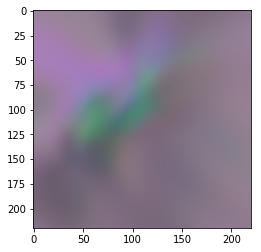

 10%|█         | 50/500 [00:14<01:47,  4.19it/s]

cost -0.4811863601207733


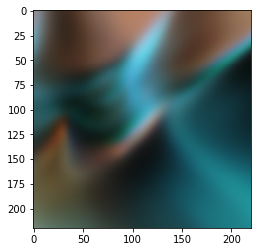

 20%|██        | 100/500 [00:26<01:35,  4.19it/s]

cost -0.5420960187911987


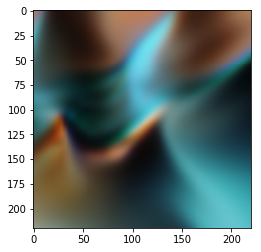

 30%|███       | 150/500 [00:38<01:23,  4.17it/s]

cost -0.5740963220596313


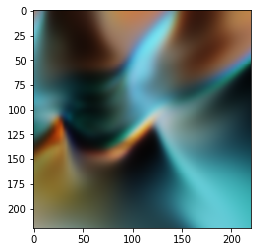

 40%|████      | 200/500 [00:50<01:12,  4.17it/s]

cost -0.5744278430938721


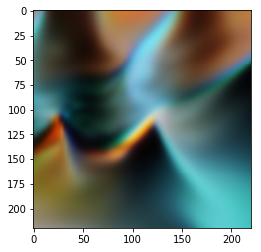

 50%|█████     | 250/500 [01:02<01:00,  4.15it/s]

cost -0.5718775391578674


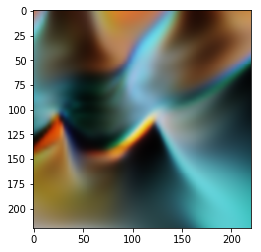

 60%|██████    | 300/500 [01:15<00:48,  4.16it/s]

Changed learning rate to 0.0009000000000000001
cost -0.579680860042572


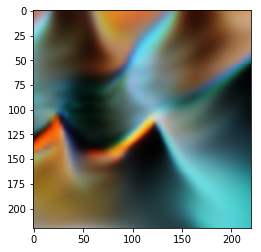

 70%|███████   | 350/500 [01:27<00:36,  4.15it/s]

cost -0.6029324531555176


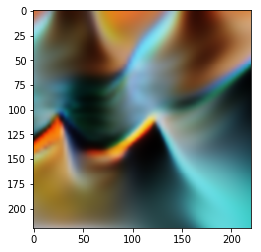

 80%|████████  | 400/500 [01:39<00:24,  4.15it/s]

cost -0.5862993001937866


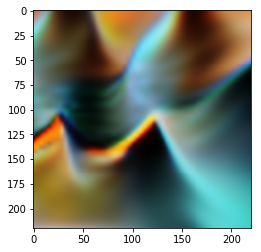

 90%|█████████ | 450/500 [01:51<00:12,  4.16it/s]

cost -0.6082421541213989


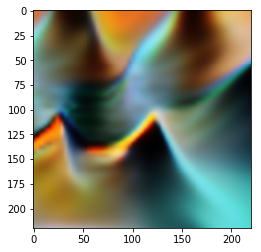

100%|██████████| 500/500 [02:03<00:00,  4.15it/s]


Took 123.7314076423645 seconds
Saving 0


  0%|          | 0/500 [00:00<?, ?it/s]

Training 1
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])
cost -0.005545265972614288


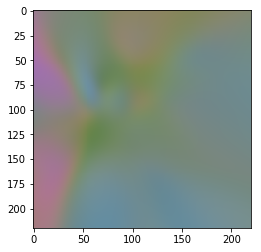

 10%|█         | 50/500 [00:11<01:48,  4.16it/s]

cost -0.043805889785289764


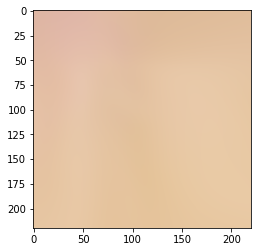

 20%|██        | 100/500 [00:24<01:37,  4.12it/s]

cost -0.09508244693279266


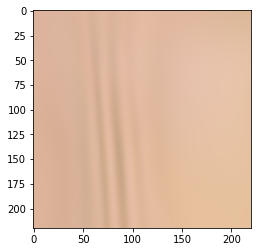

 30%|███       | 150/500 [00:36<01:25,  4.11it/s]

cost -0.17176342010498047


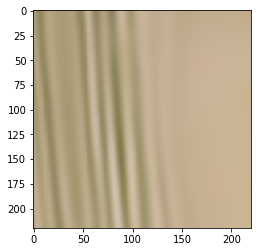

 40%|████      | 200/500 [00:48<01:12,  4.14it/s]

cost -0.22941714525222778


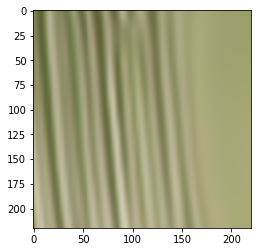

 50%|█████     | 250/500 [01:00<01:01,  4.07it/s]

cost -0.27212971448898315


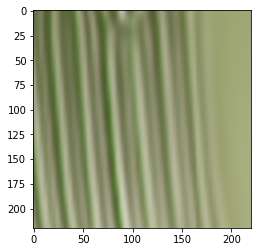

 60%|██████    | 300/500 [01:12<00:49,  4.05it/s]

Changed learning rate to 0.0009000000000000001
cost -0.2999159097671509


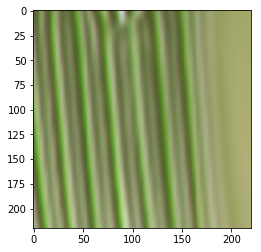

 70%|███████   | 350/500 [01:25<00:36,  4.12it/s]

cost -0.32091277837753296


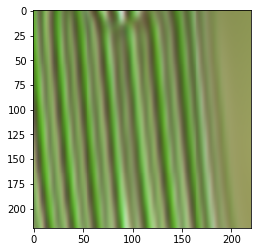

 80%|████████  | 400/500 [01:37<00:24,  4.08it/s]

cost -0.32396402955055237


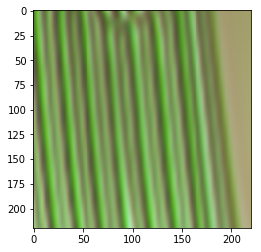

 90%|█████████ | 450/500 [01:49<00:12,  4.14it/s]

cost -0.35691311955451965


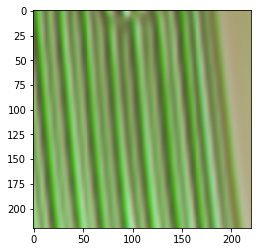

100%|██████████| 500/500 [02:02<00:00,  3.98it/s]


Took 122.3552668094635 seconds
Saving 1


  0%|          | 0/500 [00:00<?, ?it/s]

Training 2
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])
cost -0.024348169565200806


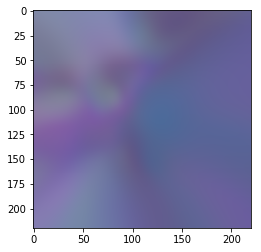

 10%|█         | 50/500 [00:12<01:48,  4.13it/s]

cost -0.5025300979614258


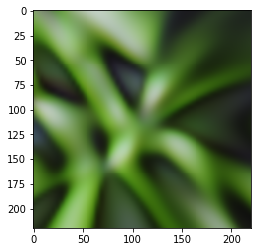

 20%|██        | 100/500 [00:24<01:38,  4.07it/s]

cost -0.7756345868110657


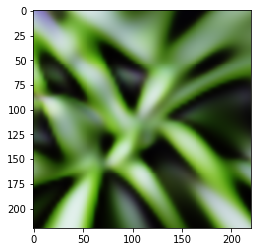

 30%|███       | 150/500 [00:36<01:25,  4.11it/s]

cost -0.9018108248710632


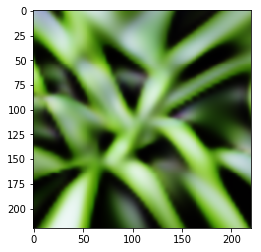

 40%|████      | 200/500 [00:49<01:12,  4.11it/s]

cost -0.967114269733429


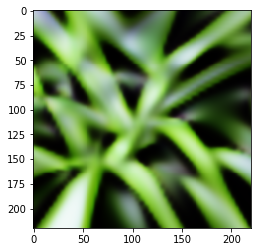

 50%|█████     | 250/500 [01:01<01:01,  4.04it/s]

cost -0.9749096035957336


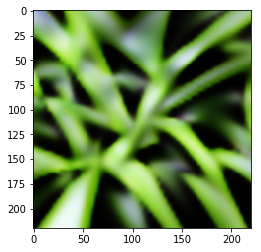

 60%|██████    | 300/500 [01:14<00:48,  4.12it/s]

Changed learning rate to 0.0009000000000000001
cost -0.9776667952537537


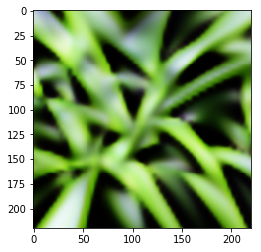

 70%|███████   | 350/500 [01:26<00:36,  4.09it/s]

cost -1.0163841247558594


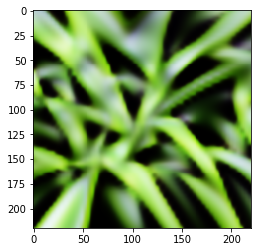

 80%|████████  | 400/500 [01:38<00:24,  4.11it/s]

cost -1.0623412132263184


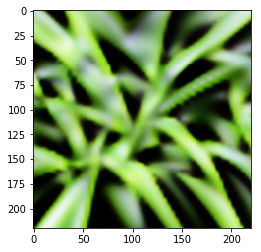

 90%|█████████ | 450/500 [01:51<00:12,  4.09it/s]

cost -1.0633492469787598


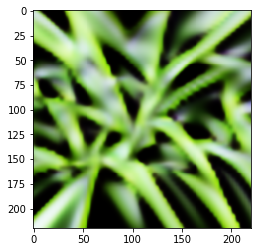

100%|██████████| 500/500 [02:03<00:00,  4.07it/s]


Took 123.98327565193176 seconds
Saving 2


  0%|          | 0/500 [00:00<?, ?it/s]

Training 3
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])
cost -0.017724908888339996


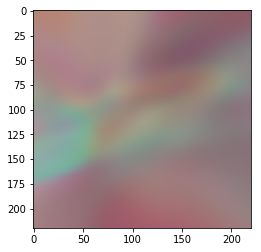

 10%|█         | 50/500 [00:12<01:51,  4.03it/s]

cost -0.9989932179450989


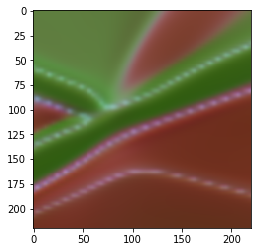

 20%|██        | 100/500 [00:24<01:38,  4.05it/s]

cost -1.1662179231643677


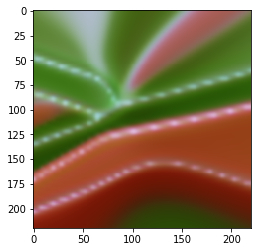

 30%|███       | 150/500 [00:37<01:25,  4.12it/s]

cost -1.2775886058807373


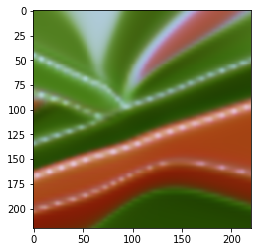

 40%|████      | 200/500 [00:49<01:13,  4.08it/s]

cost -1.2677849531173706


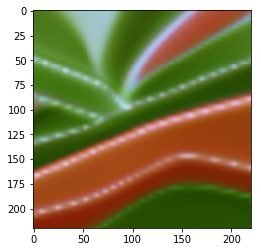

 48%|████▊     | 240/500 [00:59<01:04,  4.04it/s]

In [ ]:
for chan_to_opt in range(10000):
    log_interval = 50

    now = time.time()
    print('Training {}'.format(chan_to_opt))
    viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
    print('Took {} seconds'.format(time.time() - now))
    now = time.time()
    
    print('Saving {}'.format(chan_to_opt))
    final_ims_savedir = '../data/output_ims3/output_final_ims/'
    def save_big():
        xy_big = get_xy_mesh([277 * 2, 502 * 2]).to(device)
        res = viz(xy_big)
        imsave(get_latest_filename(final_ims_savedir), tch_im_to_np(res))
    save_big()


Saving 26
Took 1.8572006225585938 seconds
